In [ ]:
!pip install rdkit
!pip install chempy
!pip install pubchempy
!pip install pandas
!pip install py3Dmol

In [304]:
formula = input("Please enter the chemical formula you wish to analyze (e.g., 'CO2', 'C6H6', 'C4H5OH'): ")
print(f"You entered: {formula}")

Please enter the chemical formula you wish to analyze (e.g., 'CO2', 'C6H6', 'C4H5OH'): HNO3
You entered: HNO3


In [305]:
from rdkit import Chem
from chempy import Substance
from IPython.display import Image
import io
import re

subform = Substance.from_formula(formula)
atom_counts = subform.composition

def parse_chemical_formula_custom(formula_str):
    atom_counts = {}
    # Regex to find element symbols and their counts
    # Matches an uppercase letter optionally followed by a lowercase letter (element symbol)
    # then zero or more digits (count)
    pattern = r'([A-Z][a-z]*)(\d*)'
    matches = re.findall(pattern, formula_str)

    for element, count_str in matches:
        count = int(count_str) if count_str else 1
        atom_counts[element] = atom_counts.get(element, 0) + count
    return atom_counts

# Parse the chemical formula using the custom function to ensure string keys
atom_counts = parse_chemical_formula_custom(formula)

# Print the atom counts (this will now be consistent with string keys)
print(f"Parsed atom counts: {atom_counts}")

molecular_formula_elements = []
# Order of elements for molecular formula display (C, H, then others alphabetically)
ordered_elements = ['C', 'H'] + sorted([el for el in atom_counts if el not in ['C', 'H']])

for element in ordered_elements:
    count = atom_counts.get(element, 0)
    if count > 0:
        molecular_formula_elements.append(f"{element}{count if count > 1 else ''}")

pmf = "".join(molecular_formula_elements)

print(f"Precise Molecular Formula: {pmf}")

# Initialize counts for DU calculation
C = atom_counts.get('C', 0)
H = atom_counts.get('H', 0)
N = atom_counts.get('N', 0)

# Halogens (X) include F, Cl, Br, I
halogen_elements = ['F', 'Cl', 'Br', 'I']
X = 0
for halogen in halogen_elements:
    X += atom_counts.get(halogen, 0)

Parsed atom counts: {'H': 1, 'N': 1, 'O': 3}
Precise Molecular Formula: HNO3


Visualizing Compound: InChI=1S/HNO3/c2-1(3)4/h(H,2,3,4)

--- 2D Image ---


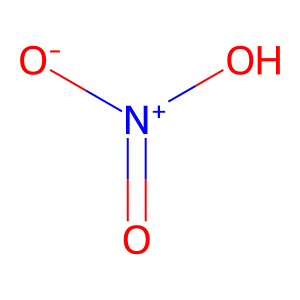


--- 3D Interactive Model ---


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [306]:
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import Image
import pubchempy as pcp
import io
import py3Dmol
import pandas as pd

# Ensure frm and sml are defined, if not already from previous cells
# Assuming pmf is correctly defined from previous steps

frm = pcp.get_cids(formula, "name", "substance", list_return="flat")

# Create a list of PubChem Compound objects
compounds_list = []
if frm: # Check if frm is not empty
    for cid in frm:
        try:
            compound = pcp.Compound.from_cid(cid)
            compounds_list.append(compound)
        except Exception as e:
            print(f"Could not retrieve compound for CID {cid}: {e}")

# Create the sml DataFrame from the compounds list
if compounds_list:
    sml = pcp.compounds_to_frame(compounds_list, properties=['inchi'])
else:
    # Create an empty DataFrame with the 'inchi' column if no compounds were retrieved
    sml = pd.DataFrame(columns=['inchi'])

# Check if sml is not empty and contains 'inchi' column
if not sml.empty and 'inchi' in sml.columns:
    # Select the first inchi string from the DataFrame for visualization
    itv = sml['inchi'].iloc[0]
    print(f"Visualizing Compound: {itv}")

    # Create an RDKit molecule object from the selected inchi string
    mol = Chem.MolFromInchi(itv, sanitize=True)

    if mol is not None:
        # --- Generate and display 2D image ---
        print("\n--- 2D Image ---")
        pil_img = Chem.Draw.MolToImage(mol)
        buffer = io.BytesIO()
        pil_img.save(buffer, format='PNG')
        img_bytes = buffer.getvalue()
        display(Image(img_bytes))

        # --- Generate and display 3D image ---
        print("\n--- 3D Interactive Model ---")
        # Add hydrogens for better 3D geometry generation
        mol_with_h = Chem.AddHs(mol)

        # Generate 3D coordinates using ETKDGv3 (a conformer generation algorithm)
        # and optimize the geometry using MMFF force field
        AllChem.EmbedMolecule(mol_with_h, AllChem.ETKDGv3())
        AllChem.MMFFOptimizeMolecule(mol_with_h)

        # Convert RDKit molecule to PDB format for py3Dmol
        pdb_block = Chem.MolToPDBBlock(mol_with_h)

        # Create py3Dmol viewer
        view = py3Dmol.view(width=400, height=300)
        view.addModel(pdb_block, 'pdb')
        view.setStyle({'stick':{}})
        view.zoomTo()
        view.show()

    else:
        print("Could not generate RDKit molecule from the selected inchi.")
else:
    print(f"No inchi strings found for formula {formula} on PubChem, or DataFrame is empty.")

Displaying 3 isomers found for HNO3:
Compound (SMILES: O=[N+]([O-])O):


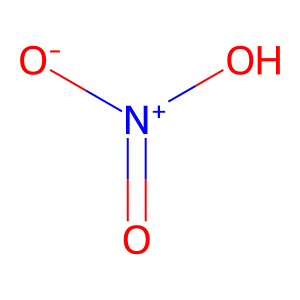



Compound (SMILES: O=NOO):


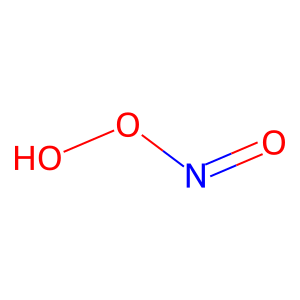



Compound (SMILES: [2H]O[N+](=O)[O-]):


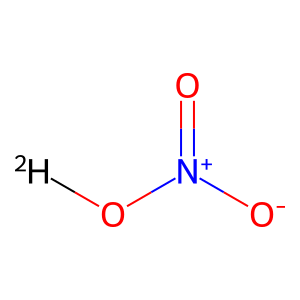

In [307]:
from rdkit import Chem
from IPython.display import Image
import io

print(f"Displaying {len(sml)} isomers found for {pmf}:")

# Check if sml is not empty
if not sml.empty:
    for index, row in sml.iterrows():
        inchi_string = row['inchi']
        # Convert InChI to RDKit Mol object
        mol = Chem.MolFromInchi(inchi_string, sanitize=True)

        if mol is not None:
            # Try to get SMILES from mol object for display, if InChI was used
            smiles_from_mol = Chem.MolToSmiles(mol)
            print(f"Compound (SMILES: {smiles_from_mol}):")

            # Generate 2D image
            pil_img = Chem.Draw.MolToImage(mol, size=(300, 300))
            buffer = io.BytesIO()
            pil_img.save(buffer, format='PNG')
            img_bytes = buffer.getvalue()
            display(Image(img_bytes))
        else:
            print(f"Could not generate RDKit molecule from InChI: {inchi_string}")
        print("\n") # Add a newline for better separation between isomers
else:
    print(f"No isomers found for formula {pmf} on PubChem.")

Generating resonance structures for: InChI=1S/HNO3/c2-1(3)4/h(H,2,3,4)
Found 2 resonance structures:
  Resonance Structure 1 (SMILES: O=[N+]([O-])O):


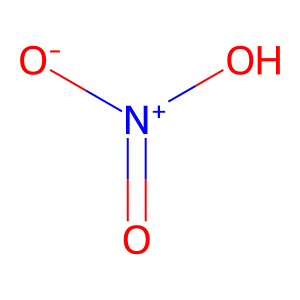



  Resonance Structure 2 (SMILES: O=[N+]([O-])O):


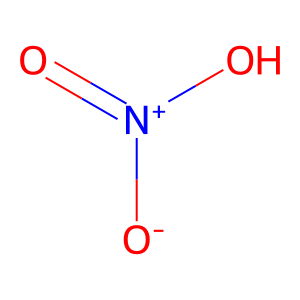

In [308]:
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import Image
import io

# We'll use the InChI string of the first compound found for resonance structure generation
# Make sure sml is not empty
if not sml.empty:
    inchi_for_resonance = sml['inchi'].iloc[0]
    print(f"Generating resonance structures for: {inchi_for_resonance}")

    # Convert InChI to RDKit Mol object
    mol_for_resonance = Chem.MolFromInchi(inchi_for_resonance, sanitize=True)

    if mol_for_resonance is not None:
        # Generate resonance structures
        # Correctly construct flags for ResonanceMolSupplier
        flags = 0

        res_mols = AllChem.ResonanceMolSupplier(mol_for_resonance, flags, maxStructs=20)

        print(f"Found {len(res_mols)} resonance structures:")
        for i, res_mol in enumerate(res_mols):
            if res_mol is not None:
                # Generate SMILES for the resonance structure for printing
                res_smiles = Chem.MolToSmiles(res_mol)
                print(f"  Resonance Structure {i+1} (SMILES: {res_smiles}):")

                # Generate 2D image for the resonance structure
                pil_img = Chem.Draw.MolToImage(res_mol, size=(300, 300))
                buffer = io.BytesIO()
                pil_img.save(buffer, format='PNG')
                img_bytes = buffer.getvalue()
                display(Image(img_bytes))
            else:
                print(f"  Could not generate RDKit molecule for resonance structure {i+1}.")
            print("\n")
    else:
        print("Could not generate RDKit molecule from the selected InChI for resonance analysis.")
else:
    print(f"No InChI strings available in sml for resonance analysis.")